In [1]:
import sys  
sys.path.insert(1, '.\..\..\SOURCES\.')

import random

random.seed(10)

from DATA import MG17
from Reservoir import Reservoir

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np

In [3]:
data = MG17(True, [90,0,10])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()


In [4]:
from IPReservoir import IPReservoir
from ESN import EchoStateNetwork
from IPMask import IPMask
from Reservoir import Reservoir
from Metrics import *

In [5]:
small_gauss = IPReservoir(N=100, desired_rho=0.7, bias=True, mask=IPMask.gaussian(N=100, std=0.2),)
small_bim = IPReservoir(N=50, desired_rho=0.7, bias=True, mask=IPMask.bimodal(N=50, mu=0.85, std=0.15))
trim =IPReservoir(N=150, desired_rho=0.7, bias=True, mask=IPMask.trimodal(N=150, linear_rate=2/3, mu=0.85, std_bim=0.15))
big_gauss = IPReservoir(N=150, desired_rho=0.7, bias=True, mask=IPMask.gaussian(N=150, std=0.2),)
big_bim = IPReservoir(N=150, desired_rho=0.7, bias=True, mask=IPMask.bimodal(N=150, mu=0.85, std=0.15))

In [8]:
big_gauss = IPReservoir(N=150, desired_rho=0.7, bias=True, mask=IPMask.gaussian(N=150, std=0.2),)
big_bim = IPReservoir(N=150, desired_rho=0.7, bias=True, mask=IPMask.bimodal(N=150, mu=0.85, std=0.15))

In [10]:
for model in [small_gauss, small_bim, trim, big_gauss, big_bim]: 
    model.IP_online(U=X_TR,eta=0.00001, epochs=5)

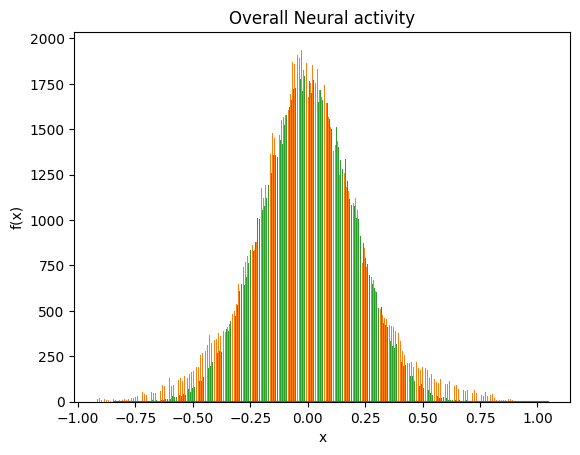

In [17]:
small_gauss.plot_neural_activity(X_TS)

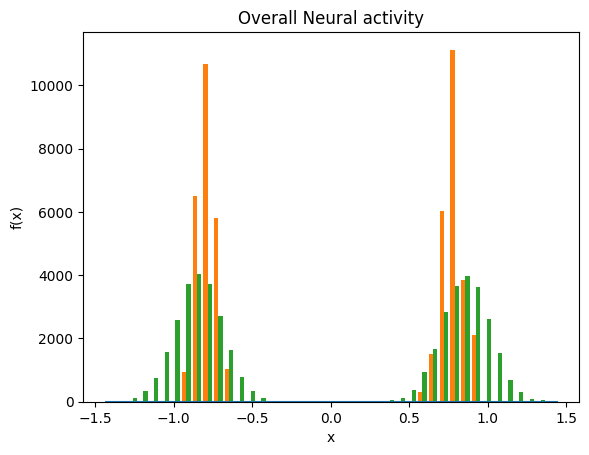

In [18]:
small_bim.plot_neural_activity(X_TS)

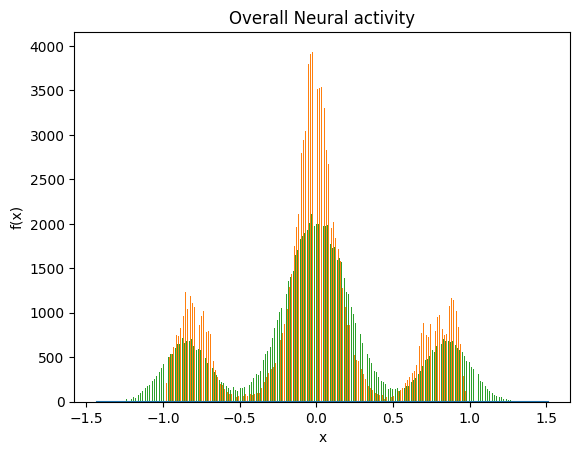

In [19]:
trim.plot_neural_activity(X_TS)

In [39]:
def joint_predic(U, return_z = False): 
    H_gauss, Z_gauss = small_gauss.predict(U, return_z=True)
    H_bim, Z_bim = small_bim.predict(U, return_z = True)

    H = torch.cat([H_gauss, H_bim], dim=1)
    Z = torch.cat([Z_gauss, Z_bim], dim=1)
    return (H,Z) if return_z == True else H

In [40]:
def joint_reset(): 
    small_gauss.reset_initial_state()
    small_bim.reset_initial_state()

In [23]:
trim.rho()

tensor(0.9623)

In [24]:
ensemble_reservoir = IPReservoir(N=150, mask=IPMask.trimodal(N=150, linear_rate=2/3, mu=0.85, std_bim=0.15) )
ensemble_reservoir.predict = joint_predic
ensemble_reservoir.reset_initial_state = joint_reset

In [25]:
ensemble_reservoir.predict = joint_predic

In [26]:
ensemble_reservoir.reset_initial_state = joint_reset

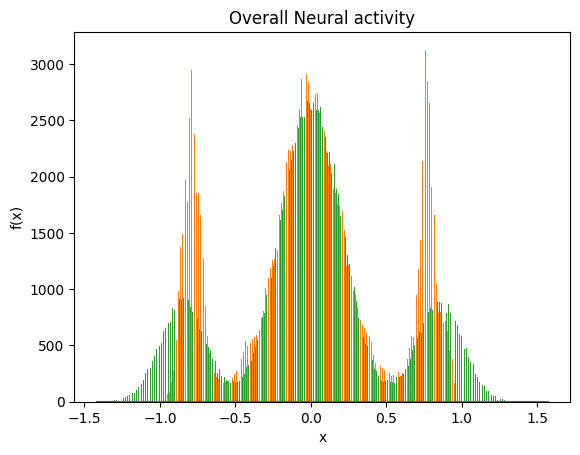

In [27]:
ensemble_reservoir.plot_neural_activity(X_TS,)

In [30]:
model_names =  ["Small Gauss", "Small Bim", "Big Gauss", "Big Bim", "Trim", "Ensemble"]

In [41]:
repetitions = 10

In [43]:
results = []
for _ in range(repetitions):
    small_gauss = IPReservoir(N=100, desired_rho=0.7, bias=True, mask=IPMask.gaussian(N=100, std=0.2),)
    small_bim = IPReservoir(N=50, desired_rho=0.7, bias=True, mask=IPMask.bimodal(N=50, mu=0.85, std=0.15))
    trim =IPReservoir(N=150, desired_rho=0.7, bias=True, mask=IPMask.trimodal(N=150, linear_rate=2/3, mu=0.85, std_bim=0.15))
    big_gauss = IPReservoir(N=150, desired_rho=0.7, bias=True, mask=IPMask.gaussian(N=150, std=0.2),)
    big_bim = IPReservoir(N=150, desired_rho=0.7, bias=True, mask=IPMask.bimodal(N=150, mu=0.85, std=0.15))
    
    for model in [small_gauss, small_bim, trim, big_gauss, big_bim]: 
        model.IP_online(U=X_TR,eta=0.00001, epochs=5)

    ensemble_reservoir = IPReservoir(N=150, mask=IPMask.trimodal(N=150, linear_rate=2/3, mu=0.85, std_bim=0.15) )
    ensemble_reservoir.predict = joint_predic
    ensemble_reservoir.reset_initial_state = joint_reset
    # initialize
    for idx, model in enumerate([small_gauss, small_bim, big_gauss, big_bim, trim, ensemble_reservoir]):
        row = [model_names[idx], idx]# models: 
        row.append(MC(UNIFORM(size=3000)).evaluate(model))
        row.append(DeltaPhi().evaluate(model))
        row.append(Neff().evaluate(model))
        row.append(MLLE(X_TS).evaluate(model))
        results.append(row)

In [67]:
df = pd.DataFrame(results, columns=["Model Name", "Model Idx", "MC", "DeFi", "Neff", "MLLE"])

In [ ]:
# Function to convert tensor string to numeric value using PyTorch .item() method
def convert_to_numeric(s):
    try:
        print(s)
        numeric_value =  s.item() # Extract numeric value from string
        return numeric_value
    except:
        return None

# Apply the function using map to convert 'MC' column values
df['MC'] = df['MC'].map(convert_to_numeric)

In [71]:
df.to_csv("EnsembleResults.csv")

## Plotting Intrinsic Measurements

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric( metric_name, color_palette='Set1'):
    # Filter the dataframe to get only the relevant metric columns
    metric_cols = ['Model Name', 'Model Idx', metric_name]
    metric_df = df[metric_cols]
    
    # Calculate mean and standard deviation for each model type
    mean_std_df = metric_df.groupby('Model Name').agg({metric_name: ['mean', 'std']})
    mean_std_df.columns = mean_std_df.columns.droplevel()
    
    # Reset index for easier plotting
    mean_std_df.reset_index(inplace=True)
    
    # Plot using seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))  # Increase figure size
    sns.barplot(x='Model Name', y='mean', data=mean_std_df, palette=color_palette, alpha=0.7)
    
    # Add filled error bands
    for i, (_, row) in enumerate(mean_std_df.iterrows()):
        plt.fill_between([i - 0.3, i + 0.3], row['mean'] - row['std'], row['mean'] + row['std'], color='gray', alpha=0.3)  # Customize error bands
    
    # Add values on top of each bar
    for i, (_, row) in enumerate(mean_std_df.iterrows()):
        plt.text(i, row['mean'], f'{row["mean"]:.2f}', ha='center', va='bottom', fontsize=10)  # Add value label
    
    # Add labels and title
    #plt.xlabel('Model Type', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    #plt.title(f'Mean and Std Dev of {metric_name} for Each Model Type', fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(range(len(mean_std_df)), mean_std_df['Model Name'], rotation=45, ha='right')
    
    # Add grid lines
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming df is your DataFrame
# plot_metric(df, 'MC', color_palette='husl')

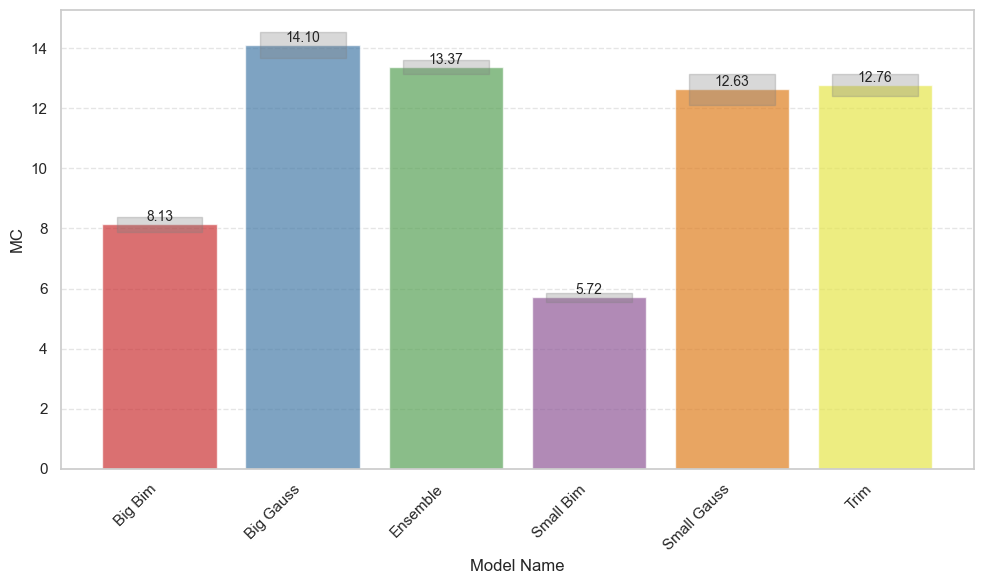

In [116]:
plot_metric("MC")

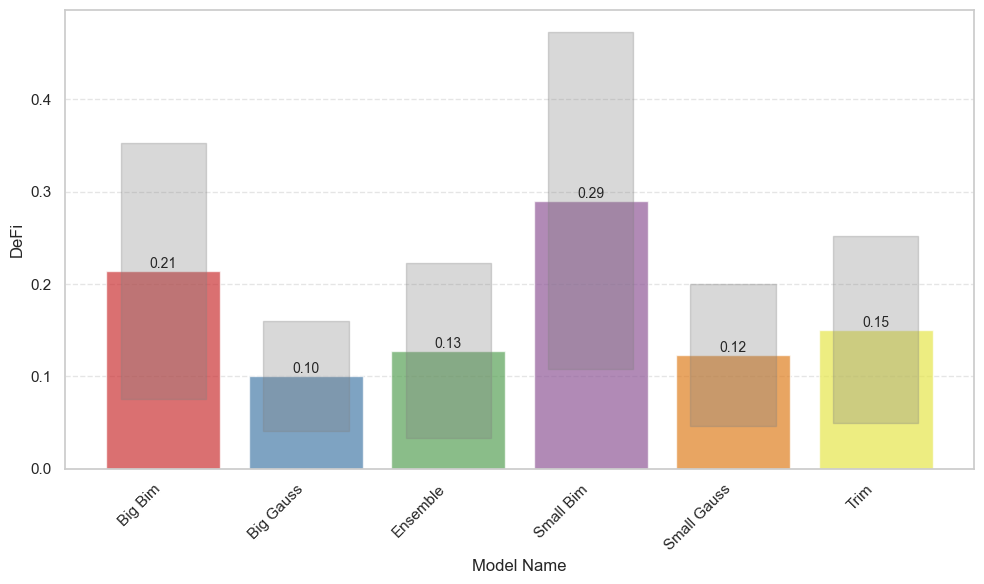

In [117]:
plot_metric("DeFi")

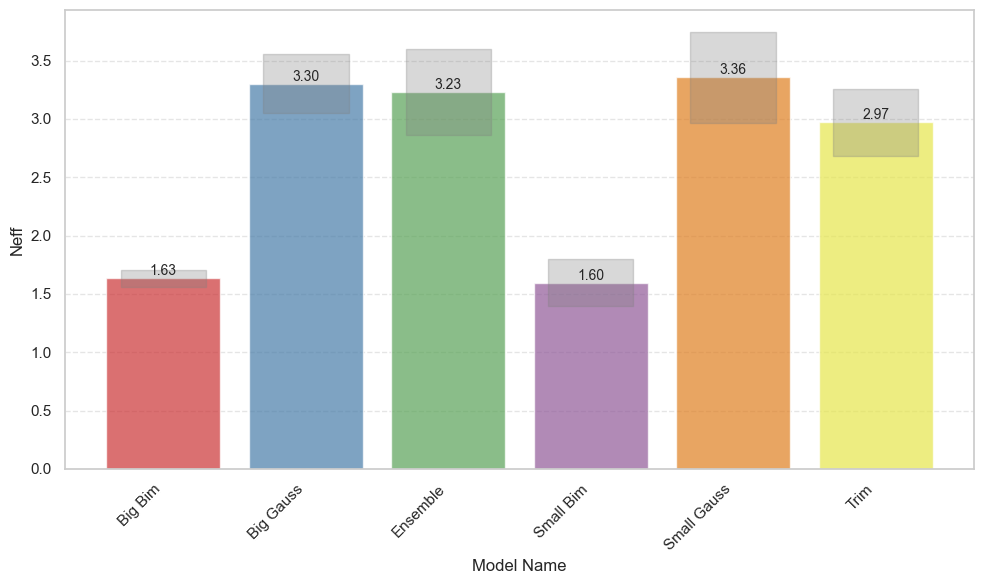

In [120]:
plot_metric("Neff")

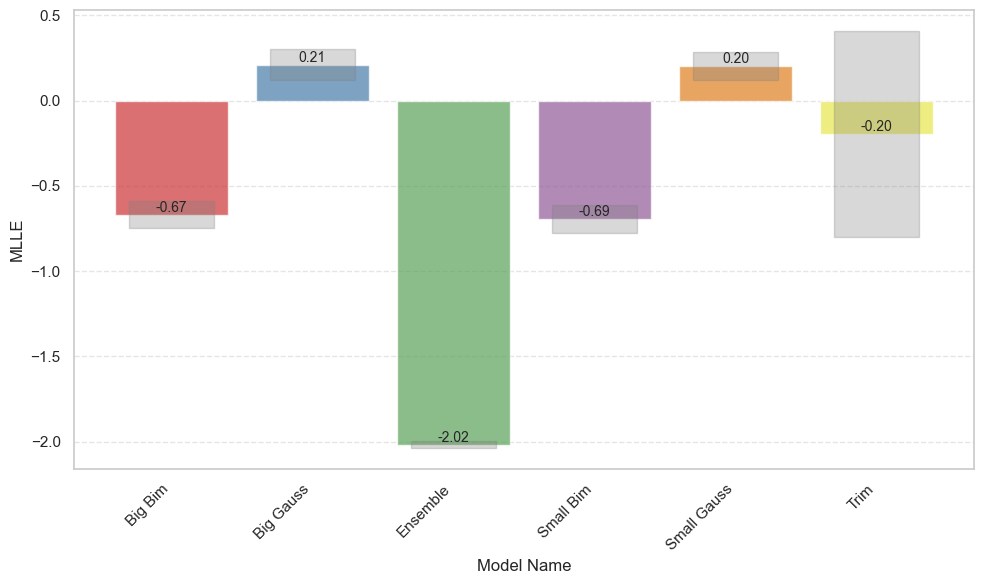

In [119]:
plot_metric("MLLE")

## Weights Heatmap

In [41]:
def wiehgts_heatmap(matrix):    
    matrix_np = matrix.numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_np, cmap='viridis')
    plt.title('Heatmap of Matrix')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [42]:
def evaluate_ensemble_rho(): 
    W_h_ensemble = torch.zeros(150,150)
    W_h_ensemble[0:100, 0:100] = gauss.W_h
    W_h_ensemble[100:150, 100:150] = bim.W_h

      # Convert PyTorch tensor to numpy array
    matrix_np = W_h_ensemble.numpy()

    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_np, cmap='viridis')
    plt.title('Heatmap of Matrix')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()
    
    eigenvalues = np.linalg.eigvals(matrix_np)
    spectral_radius = np.max(np.abs(eigenvalues))
    
    return spectral_radius

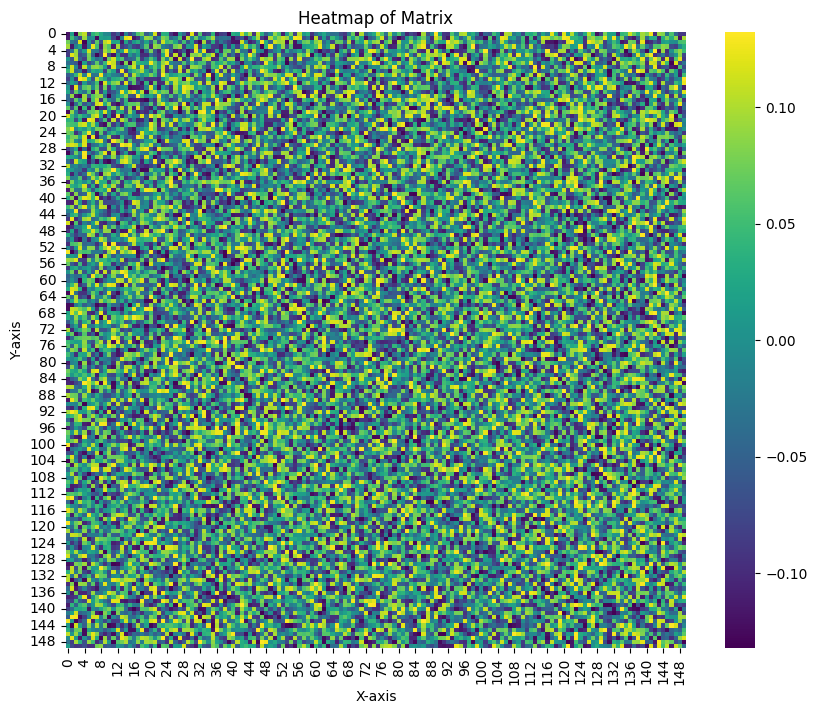

In [31]:
wiehgts_heatmap(trim.W_h)

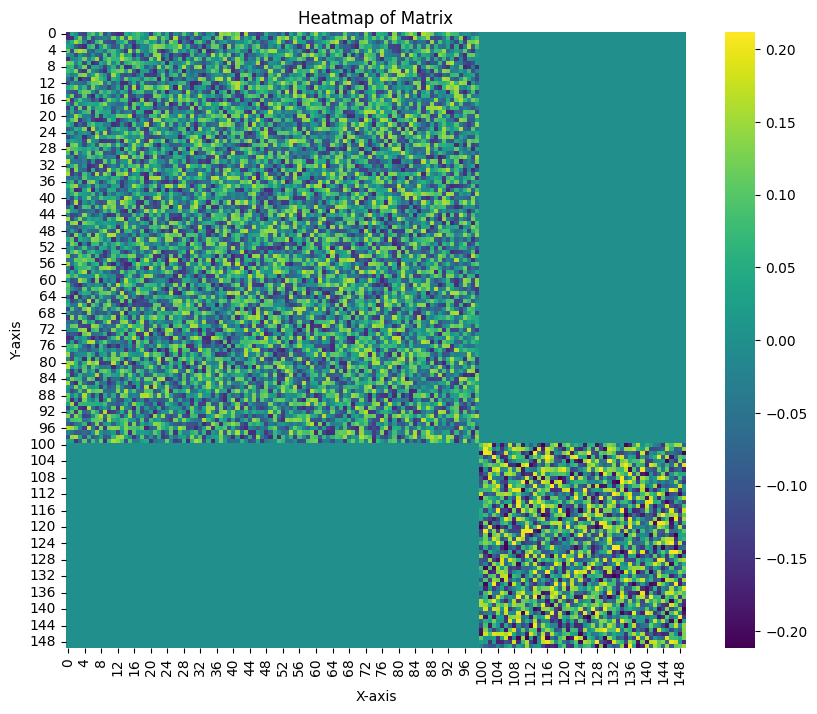

0.9623319

In [32]:
evaluate_ensemble_rho()

## What if the ensemble is further trained?

In [45]:
KL(X_TS).evaluate(ensemble_reservoir)

tensor(0.2190)

In [46]:
KL(X_TS).evaluate(trim)

tensor(0.0242)